In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs

In [2]:
data = pd.read_csv('data3a.csv',dtype={"y": int, "x": float, "f": "category"})
data

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C
...,...,...,...
95,8,9.15,T
96,6,8.52,T
97,8,10.24,T
98,7,10.86,T


dataについて、各項目は以下  
y : 種子数, x : 植物の大きさ f : c or t {c:処理なし,t:施肥処理}

In [3]:
# データの次元を確認
data.shape

(100, 3)

# それぞれのデータについて、最初の5行を出力してみる

In [4]:
data.y.head()

0     6
1     6
2     6
3    12
4    10
Name: y, dtype: int32

In [5]:
data.x.head()

0     8.31
1     9.44
2     9.50
3     9.07
4    10.16
Name: x, dtype: float64

In [6]:
data.f.head()

0    C
1    C
2    C
3    C
4    C
Name: f, dtype: category
Categories (2, object): ['C', 'T']

# データの概要確認

In [7]:
data.describe()

,y,x
count,100.000000,100.000000
mean,7.830000,10.089100
std,2.624881,1.008049
min,2.000000,7.190000
25%,6.000000,9.427500
50%,8.000000,10.155000
75%,10.000000,10.685000
max,15.000000,12.400000


In [8]:
data.f.describe()

count     100
unique      2
top         T
freq       50
Name: f, dtype: object

data.fについては、一般に1または0に変換する。

# 図を描いてデータ確認

Text(0, 0.5, 'Y')

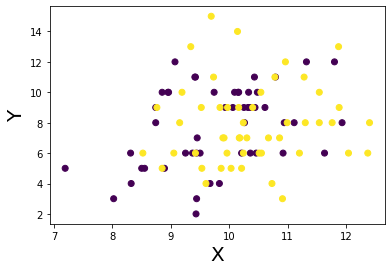

In [9]:
plt.scatter(data.x, data.y, c=data.f.cat.codes)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)

<AxesSubplot:title={'center':'y'}, xlabel='f'>

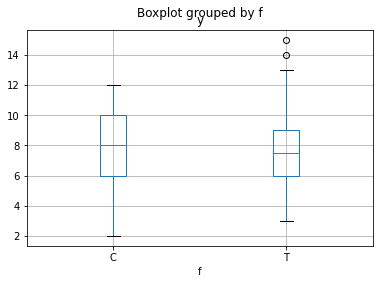

In [10]:
data.boxplot(column='y', by='f')

プロットを見た感覚としては  
- サイズxが増えると種子数も増えそうだけど、はっきりしない
- 肥料の効果は見えてこない

# ポアソン分布を仮定してデータを表現
- 個体ごとの平均種子数$ \lambda_i $が対サイズxと施肥処理fに影響される

線形予測しまずは個体iの対サイズ$ x_i $だけに依存する統計モデルを考える

# 線形予測子とリンク関数
今回、個体ごとに異なる平均$ \lambda_i $を説明変数$ x_i $の関数として下記の様に定義する。
$$
\lambda_i = e^{\beta_1 + \beta_2x_i}
$$
上記の様に定義する理由は、$ \lambda_i $がポアソン分布の特徴である非負性を有するように定義できるからである。 
ここで上記の対数をとることで、$ \lambda_i $を$ \beta $の線形結合で表現できる
$$
log\lambda_i = \beta_1 + \beta_2x_i
$$
この時、右辺のことを**線形予測子**、左辺のことを**対数リンク関数(対数でない場合はリンク関数)**と呼ぶ。  
それぞれ仮定する分布に対して都合のよい性質を持つ関数があり、それらを**正準リンク関数**と呼ぶ。  

## 当てはまりの良さ
ポアソン分布を仮定した際の対数尤度は
$$
logL(\beta_1,\beta_2) = \sum_{i}log\frac{\lambda_i^{y_i}e^{-\lambda_i}}{y_i!}
$$
※この時、$ \lambda_i $は$ \beta_1,\beta_2 $の関数であることに注意！   
$ \beta_1,\beta_2 $という複数パラメータを扱うとき、数学的導出により最尤推定値を特定するのは困難。    
なので、**数値的な試行錯誤**によって導出する。

# $ \beta_1,\beta_2 $の数値的試行錯誤による導出

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
model = smf.glm('y ~ x', data=data, family=sm.families.Poisson())

In [12]:
result = model.fit()

In [13]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Sat, 24 Jul 2021   Deviance:                       84.993
Time:                        09:27:20   Pearson chi2:                     83.8
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2917      0.364      3.552      0.000       0.579       2.005
x              0.0757      0.036      2.125      0.034       0.006       0.145
==============================================================================
"""

## 上の結果から読み解けること
$\beta_1,\beta_2$の値は、それぞれ$\beta_1:1.2917,\beta_2:0.0757と導かれた。 
stdは標準誤差であり、推定値のばらつきは正規分布と仮定し、さらに対数尤度関数の最大値付近での形がその正規分布に近いと仮定して算出。   
z値は推定値 ÷ 標準誤差で算出され、z値はN(推定値, 1)の正規分布とみることができる。   
この時のP値はZが0以下となる確率の二倍である。


**最大対数尤度を算出**

In [16]:
result.llf

-235.38625076986077

# ポアソン回帰モデルによる予測

上記の結果より、平均種子数\lambdaの関数は以下の様に推定される
$$
\lambda = e^{1.2917 + 0.0757x}
$$

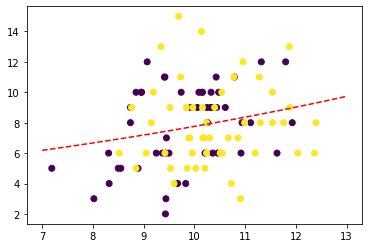

In [19]:
# 7～13まで100個のデータを用意
x = np.linspace(7,13,100)
# 用意したデータを上記回帰式に入れて、yを推定
y = np.exp(result.params['Intercept'] + result.params['x']*x)

# 標本データの種子数と対サイズをプロット
plt.scatter(data.x,data.y,c=data.f.cat.codes)

# 予測させたyとxを点線でプロット
plt.plot(x,y,"r--")
plt.show()

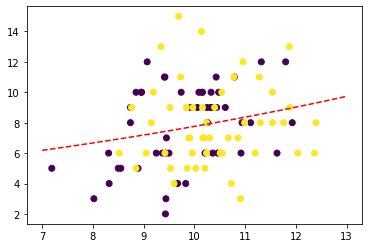

In [20]:
# 上記は次の様にもかける
x = np.linspace(7,13,100)

plt.scatter(data.x,data.y,c=data.f.cat.codes)
plt.plot(x,result.predict({'x':x}),'r--')
plt.show()

# 説明変数が因子型のモデル

因子型の場合、因子型の説明変数（カテゴリ変数）をダミー変数に置き換える。
今回だと、
$$
\lambda_i = e^{\beta_1 + \beta_3d_i}\\
$$
ただし、
$$
    d_i =
    \begin{cases}
        0 \quad (f_i = C)\\
        1 \quad (f_i = T)\\
    \end{cases}
$$

これは、仮にカテゴリ変数$ f_i $のとりうる値が$ f_i\in{C,TA,TB} $の様にカテゴリ数が多い場合でも、以下の様に表現できる
$$
\lambda_i = e^{\beta_1 + \beta_3d_{i,A} + \beta_4d_{i,B}}\\
$$
ただし、
$$
\begin{align}
d_{i,A} &=
    \begin{cases}
        0 \quad (f_i=TA)\\
        1 \quad (f_i \not= TA)\\
    \end{cases}\\
    d_{i,B} &=
    \begin{cases}
        0 \quad (f_i=TA)\\
        1 \quad (f_i \not= TA)\\
    \end{cases}
\end{align}
$$

In [22]:
model = smf.glm('y ~ f',data=data,family=sm.families.Poisson())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -237.63
Date:                Sat, 24 Jul 2021   Deviance:                       89.475
Time:                        13:35:59   Pearson chi2:                     87.1
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0516      0.051     40.463      0.000       1.952       2.151
f[T.T]         0.0128      0.071      0.179      0.858      -0.127       0.153
==============================================================================
"""

## 最大対数尤度？

In [23]:
result.llf

-237.62725696068685

上記の結果について、最大対数尤度が小さくなっているから、xだけのモデルより、**あてはまりが悪くなっている**といえる.

# 説明変数が数量型 + 因子型の統計モデル

GLM（一般線形化モデル）では、複数の説明変数の効果は線形予測子の中で和として表現される。
今回は
$$
log\lambda_i = \beta_1 + \beta_2x_i + \beta_3d_i
$$

In [24]:
# データの確認
data.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


In [25]:
model = smf.glm('y~x+f',data=data,family=sm.families.Poisson())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.29
Date:                Sat, 24 Jul 2021   Deviance:                       84.808
Time:                        13:46:55   Pearson chi2:                     83.8
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2631      0.370      3.417      0.001       0.539       1.988
f[T.T]        -0.0320      0.074     -0.430      0.667      -0.178       0.114
x              0.0801      0.037      2.162      0.031       0.007       0.153
==============================================================================
"""

上記の結果より、fの係数は先ほどは平均種子数に対して正の効果を与えていたが、今回は負の効果となっている。肥料の効果はあるのか?

# 対数リンク関数のわかりやすさ：掛け算される効果

なにが言いたいかというと、$\lambda_i$は$f_i$がCなら
$$
\lambda_i = e^{1.26+0.08x_i}
$$
であり、$ f_i $がTなら
$$
\lambda_i = e^{1.26+0.08x_i-0.032}
$$
である。これは、以下の様に分解できる
$$
\lambda_i = e^{1.26}\times e^{0.08x_i}\times e^{-0.032}
$$
となり、$ x_i,f_i $の変化が掛け算で$ \lambda_i $に影響を与えているということ

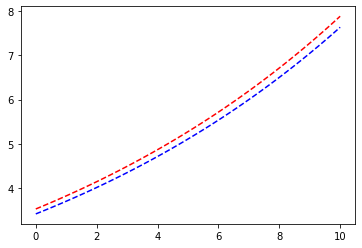

In [49]:
# 対数リンク関数のとき、カテゴリ変数の違いでどれだけ変わるか

# 7～13までの区間を100個で区切り、変数xへ
x = np.linspace(0,10,100)
c = []
t = []
for i in range(100):
    c.append('C')
    t.append('T')
plt.plot(x,result.predict({'x':x,'f':c}),'r--')
plt.plot(x,result.predict({'x':x,'f':t}),'b--')
plt.show()

# リンク関数が恒等リンク関数のとき
つまり、
$$
\lambda_i = \beta_1 + \beta_2x_i + \beta_3d_i
$$
のとき

In [57]:
# リンク関数が特に何もない：恒等リンク関数のとき
model = smf.glm('y~x+f',data=data,family=sm.families.Gaussian())
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          6.6522
Method:                          IRLS   Log-Likelihood:                -235.12
Date:                Sat, 24 Jul 2021   Deviance:                       645.26
Time:                        20:58:44   Pearson chi2:                     645.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6169      2.653      0.610      0.542      -3.582       6.816
f[T.T]        -0.2538      0.537     -0.472      0.637      -1.307       0.800
x              0.6284      0.268      2.345      0.019       0.103       1.154
==============================================================================
"""

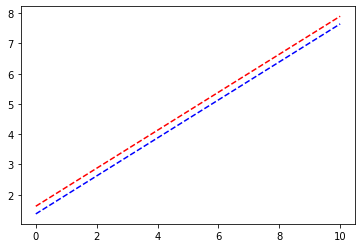

In [58]:
# 7～13までの区間を100個で区切り、変数xへ
x = np.linspace(0,10,100)
c = []
t = []
for i in range(100):
    c.append('C')
    t.append('T')
plt.plot(x,result.predict({'x':x,'f':c}),'r--')
plt.plot(x,result.predict({'x':x,'f':t}),'b--')
plt.show()

対数リンク関数と恒等リンク関数を使用した際に、まったく意味合いの違うものになっていることに気づく.   
恒等リンク関数を使用した際の主張は、
- 平均種子数が1であろうが1000であろうが,施肥処理による影響は同じ
対数リンク関数では
- 複数の効果が掛け算で影響する

と考えており、リンク関数をどのようにとるかによって全く別物になる。  
パラメータ推定ができればどんなモデルでもよいのではなく、数式がどのように減少を表現するかを注意して統計モデルを設計するべし！    
**数式は現象に対しての表現である！！**

# 何でも正規分布、何でも直線には無理がある
単回帰、重回帰などの回帰は一般化線形モデル（GLM:generalized linear model）の一部である。    
※誤差の分布に等分散性と正規分布を仮定したものが単回帰並びに重回帰である。   
しかし、実際のデータを見てみると、そもそも等分散じゃないだとか、離散データだったり、非負のデータだったり…考えなしに正規分布を仮定し、直線を引いて回帰することは全く意味がない   
そのため、まとめとして以下に気を付けること
- 統計モデルを作るときは、データを図示したうえで特性を理解する
- 理解した特性を表現できる分布、モデルは何か考える
- GLMは確率分布、リンク関数、線形予測子を指定する統計モデル

GLMはデータに合わせて確率分布、リンク関数を選んで事象を表現できる。 
モデルはデータを表現するために選ぶ!前に進むために考えなしに使うものでない!